# <center>Appendix</center> Dane Jordan
## Project: Part 2

### Import necessary libraries (for both AWS Spark and non-AWS)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

%matplotlib inline

### Import pyspark libraries (for use on AWS)

In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

### Create spark session

In [2]:
spark = SparkSession.builder.appName('Python Spark SQL basic example').config('spark.some.config.option',
                                                                              'some-value').getOrCreate()

### Research Questions:
_Unless explicitly noted, the instance types used for the master and the core(s) is m3.2xlarge._

1. __Does increasing the number of partitions decrease run time?__  
For this I will compare the run times of a DataFrame that has been partitioned into 1 partition and another DataFrame of the same data that has been partitioned into 2 partitions. The number of instances (2), file size (100%), and number of components for the gmm (7) will remain the same among the cases below.

  1. 1 partition
  2. 2 partitions

2. __Does decreasing the file size decrease run time?__
For this I will compare the run times when the data is subsetted into file sizes that are 75%, 50%, and 25% of the original file size. The number of instances (2), number of partitions (2), and number of components for the gmm (7) will remain the same among the cases below.

  1. 75% size file
  2. 50% size file
  3. 25% size file
  4. compare A, B, and C with RQ1.B

3. __Does decreasing the number of components used to fit the gmm decrease run time?__  
For this I will compare the run times when the data is fit to a gmm with 5 components and a gmm with 7 components. The number of instances (1), number of partitions (2), and file size (100%) will remain the same among the cases below.

  1. fit gmm with 5 components, 1 instance
  2. fit gmm with 7 components, 1 instance

4. __Does increasing the number of instances decrease run time?__
Based on the homework 2, I do not expect a change in the number of instances to change the run time, however, I feel it prudent to establish this prior to investigating the next RQ. For this I will compare the run times when the data is fit to a gmm on 2 instances, and when the data is fit to a gmm on 4 instances. The number of partitions (2), file size (100%), and components for the gmm (7) will remain the same among the cases below.

  1. 4 instances
  2. compare A with RQ1.B

5. __Does changing the instance type of the core instances, not the master, to a smaller instance type on AWS increase run time?__  
For this I will compare the run times with 2 instances of the m3.2xlarge cores with that of 2 instances of the m2.xlarge cores. While I expect that the m3.2xlarge cores will run faster, this serves to establish a base line for the subsequent question in which the number of instances of m2.xlarge cores will be increased. The number of partitions (16), file size (100%), and components for the gmm (7) will remain the same among the cases below.

  1. 2 instances (m3.2xlarge)
  2. 2 instances (m2.xlarge)

6. __With a smaller instance type, does increasing the number of instances decrease run time?__
I ask this question because in homework 2 the number of instances did not affect the run times, however, I believe this was due to the number of available CPU cores being more than sufficient for the number of partitions even on a single instance. By choosing an instance with fewer CPU cores, we will see if increasing the number of instances actually decreases the run time to fit a gmm (__speed-up__). The number of partitions (4), file size (100%), and components for the gmm (7) will remain the same among the cases below.

  1. 4 instances (m2.xlarge)
  2. compare A with RQ5.B

### Read in small dataset and format for use with pyspark

In [3]:
# read in data into DataFrame
df_subset1 = spark.read.csv('s3://csed516/smalldatasetspark/wise-colors-15-20-subsetsmall8.csv',
                            header=False,
                            inferSchema=True)

# rename columns
df_subset1 = df_subset1.selectExpr('_c0 as ID', '_c1 as X', '_c2 as Y', '_c3 as Z', '_c4 as W')

# use referenced stackoverflow to merge multiple columns to a "features" column
assembler = VectorAssembler(inputCols=['X', 'Y', 'Z', 'W'], outputCol='features')

# transform the data
df_subset1 = assembler.transform(df_subset1)

# drop the original columns
df_subset1 = df_subset1.drop('X', 'Y', 'Z', 'W')

### Create smaller subsets of the small dataset
I created data sets that were 75%, 50% and 25% of the original small dataset.

In [4]:
# subset the data into 1/4, 1/2, and 3/4 of the original large dataset
df_subset4, df_subset2 = df_subset1.randomSplit([0.25, 0.75], seed=6)
df_subset3 = df_subset1.randomSplit([0.5, 0.5], seed=6)[0]

# print the number of rows and partitions in each subset
print('subset 1 - number of rows: ' + str(df_subset1.count()) + '; number of partitions: ' + str(df_subset1.rdd.getNumPartitions()))
print('subset 2 - number of rows: ' + str(df_subset2.count()) + '; number of partitions: ' + str(df_subset2.rdd.getNumPartitions()))
print('subset 3 - number of rows: ' + str(df_subset3.count()) + '; number of partitions: ' + str(df_subset3.rdd.getNumPartitions()))
print('subset 4 - number of rows: ' + str(df_subset4.count()) + '; number of partitions: ' + str(df_subset4.rdd.getNumPartitions()))

subset 1 - number of rows: 1946979; number of partitions: 8
subset 2 - number of rows: 1460144; number of partitions: 8
subset 3 - number of rows: 973967; number of partitions: 8
subset 4 - number of rows: 486835; number of partitions: 8


### Loop through various partition sizes and record the time to fit the gmm model
Depending on the parameters specified, this can take anywhere from 1-5 hours to run. For later runs, I began looking only at the subset1 data which is the entire small dataset.

In [5]:
# number of instances/type/vCPU, dimensions, and components (manually enter and change on AWS for instances)
instances = 1
instance_type = 'm2.xlarge'
vCPU = 2
dimensions = 4
components = 7

# define model
gmm = GaussianMixture().setK(components).setSeed(6)

# define DataFrame to store run times, counter for iloc insertion, and subset
run_times = pd.DataFrame(columns=['dataset', 'instances', 'instance_type',
                                  'vCPU', 'dimensions', 'components',
                                  'partitions', 'run_iteration', 'run_time'])
counter = 0
subset = 0

# loop through each data subset and record the gmm fitting times
for i in [df_subset1]:

    subset += 1
    
    # loop through powers of 2
    for j in [1, 2, 4, 8, 16, 32]:

        # repartition the data for the subset
        df_repart = i.repartition(j)
            
        # run 3 iterations--take average
        for k in range(0, 3):
            
            # update counter
            counter += 1
            
            # fit gmm model
            start = time.time()
            model = gmm.fit(df_repart)
            end = time.time()
            
            # print and store results
            print('subset' + str(subset) + ' | ' + str(j) + ' partitions' + ' | ' + 'run ' + str(k + 1) + ': ' + str(end - start) + 's')
            run_times.loc[counter] = [str('subset' + str(subset)),
                                      instances,
                                      instance_type,
                                      vCPU*instances,
                                      dimensions,
                                      components,
                                      j,
                                      k + 1,
                                      end - start]

subset1 | 1 partitions | run 1: 692.074978113s
subset1 | 1 partitions | run 2: 696.938602924s
subset1 | 1 partitions | run 3: 693.487122059s
subset1 | 2 partitions | run 1: 375.057291031s
subset1 | 2 partitions | run 2: 380.287734985s
subset1 | 2 partitions | run 3: 377.9050951s
subset1 | 4 partitions | run 1: 388.035017014s
subset1 | 4 partitions | run 2: 388.016299009s
subset1 | 4 partitions | run 3: 386.245289087s
subset1 | 8 partitions | run 1: 391.671700001s
subset1 | 8 partitions | run 2: 392.933563948s
subset1 | 8 partitions | run 3: 396.474438906s
subset1 | 16 partitions | run 1: 401.292907953s
subset1 | 16 partitions | run 2: 401.742604017s
subset1 | 16 partitions | run 3: 395.193265915s
subset1 | 32 partitions | run 1: 402.155296087s
subset1 | 32 partitions | run 2: 405.470302105s
subset1 | 32 partitions | run 3: 399.553145885s


### Write results to csv

In [6]:
run_times.to_csv('run_times.csv', index=False)

### Copy csv file to S3
The following `AWS CLI` commands were used to copy data saved to the EC2 instance to S3, and subsequently from S3 to my local machine. Variations were used when copying to not overwrite the previous file. For purposes of the commands below, only the generic form is mentioned.
```
aws s3 cp run_times.csv s3://data516-drjordan/project_part_2/

aws s3 cp s3://data516-drjordan/project_part_2/run_times.csv run_times.csv
```

### Import run time data into DataFrame (_no longer working on AWS_)

In [2]:
dfs = []
for root, dirs, files in os.walk('run_times/'):
    for file in files:
        dfs.append(pd.read_csv('run_times/' + file))
        
run_times = pd.concat(dfs, ignore_index=True)

### Total run time
For my curiosity only. I would like to see how much time was spent on AWS purely fitting the gmm model. This time does not include the ~45 minutes to start a cluster, nor the 10-20 minutes required to resize a cluster (increasing or reducing the number of instances).

In [3]:
total_seconds = run_times['run_time'].sum()
hours = np.floor(total_seconds / 3600)
minutes = np.floor((total_seconds % 3600) / 60)
seconds = np.floor((total_seconds % 3600) % 60)
print('%d hours, %d minutes, %d seconds' % (hours, minutes, seconds))

16 hours, 50 minutes, 59 seconds


### Aggregate run iterations to get an average run time for each scenario and convert to type(int)

In [4]:
run_times = run_times.groupby(['components',
                               'dataset',
                               'instance_type',
                               'instances',
                               'partitions',
                               'vCPU'], as_index=False)['run_time'].mean()

run_times.run_time = run_times.run_time.astype(int)

### Answer RQs

#### RQ1

In [5]:
run_times[(run_times['components'] == 7) &
          (run_times['dataset'] == 'subset1') &
          (run_times['instance_type'] == 'm3.2xlarge') &
          (run_times['instances'] == 2) &
          ((run_times['partitions'] == 1) | (run_times['partitions'] == 2))]

,components,dataset,instance_type,instances,partitions,vCPU,run_time
36,7,subset1,m3.2xlarge,2,1,32,519
37,7,subset1,m3.2xlarge,2,2,32,299


#### RQ2

In [6]:
run_times[(run_times['components'] == 7) &
          ((run_times['dataset'] == 'subset1') |
           (run_times['dataset'] == 'subset2') |
           (run_times['dataset'] == 'subset3') |
           (run_times['dataset'] == 'subset4')) &
          (run_times['instance_type'] == 'm3.2xlarge') &
          (run_times['instances'] == 2) &
          (run_times['partitions'] == 2)]

,components,dataset,instance_type,instances,partitions,vCPU,run_time
37,7,subset1,m3.2xlarge,2,2,32,299
49,7,subset2,m3.2xlarge,2,2,32,230
61,7,subset3,m3.2xlarge,2,2,32,157
73,7,subset4,m3.2xlarge,2,2,32,79


#### RQ3

In [7]:
run_times[((run_times['components'] == 7) | (run_times['components'] == 5)) &
          (run_times['dataset'] == 'subset1') &
          (run_times['instance_type'] == 'm3.2xlarge') &
          (run_times['instances'] == 1) &
          (run_times['partitions'] == 2)]

,components,dataset,instance_type,instances,partitions,vCPU,run_time
1,5,subset1,m3.2xlarge,1,2,16,201
31,7,subset1,m3.2xlarge,1,2,16,302


#### RQ4

In [8]:
run_times[(run_times['components'] == 7) &
          (run_times['dataset'] == 'subset1') &
          (run_times['instance_type'] == 'm3.2xlarge') &
          ((run_times['instances'] == 2) | (run_times['instances'] == 4)) &
          (run_times['partitions'] == 2)]

,components,dataset,instance_type,instances,partitions,vCPU,run_time
37,7,subset1,m3.2xlarge,2,2,32,299
43,7,subset1,m3.2xlarge,4,2,64,300


#### RQ5

In [9]:
run_times[(run_times['components'] == 7) &
          (run_times['dataset'] == 'subset1') &
          ((run_times['instance_type'] == 'm3.2xlarge') | (run_times['instance_type'] == 'm2.xlarge')) &
          (run_times['instances'] == 2) &
          (run_times['partitions'] == 16)]

,components,dataset,instance_type,instances,partitions,vCPU,run_time
16,7,subset1,m2.xlarge,2,16,4,452
40,7,subset1,m3.2xlarge,2,16,32,143


#### RQ6

In [10]:
run_times[(run_times['components'] == 7) &
          (run_times['dataset'] == 'subset1') &
          (run_times['instance_type'] == 'm2.xlarge') &
          ((run_times['instances'] == 2) | (run_times['instances'] == 4)) &
          (run_times['partitions'] == 16)]

,components,dataset,instance_type,instances,partitions,vCPU,run_time
16,7,subset1,m2.xlarge,2,16,4,452
22,7,subset1,m2.xlarge,4,16,8,277


### Visualize data
dataset size vs # of partitions  
\# of components vs # of partitions  
\# of instances vs # of partitions (m3.2xlarge)  
\# of instances vs # of partitions (m2.xlarge)  
instance type vs # of instances

In [5]:
def plot_heatmap(data, title_size=30, axis_size=30, tick_size=20, annotation_size=20, xlabel='x', ylabel='y'):
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(data, annot=True, fmt='d', annot_kws={'size': annotation_size}, cbar=False, ax=ax)
#     sns.plt.title('GMM Fit Times (s)', fontsize=title_size)
    sns.plt.xlabel(xlabel, fontsize=axis_size)
    sns.plt.xticks(fontsize=tick_size)
    sns.plt.ylabel(ylabel, fontsize=axis_size)
    sns.plt.yticks(fontsize=tick_size, rotation='horizontal')
    plt.tight_layout()
    
    
def plot_line(data, title_size=30, axis_size=30, tick_size=20, legend_size=20, xlabel='x', ylabel='y', leg_title='legend'):
    
    data.plot(x=data.columns[0], figsize=(12,8), fontsize=tick_size)
#     plt.title('GMM Fit Times (s)', fontsize=title_size)
    plt.xlabel(xlabel, fontsize=axis_size)
    plt.xticks(range(len(data.iloc[:, 0])), data.iloc[:, 0], rotation=0)
    plt.ylabel(ylabel, fontsize=axis_size)
    lg = plt.legend(title=leg_title, fontsize=legend_size)
    title = lg.get_title()
    title.set_fontsize(legend_size)
    plt.tight_layout()
    
    
def plot_bar(data, title_size=30, axis_size=30, tick_size=20, legend_size=20, xlabel='x', ylabel='y', leg_title='legend'):
    
    data.plot(x=data.columns[0], kind='bar', figsize=(12,8), fontsize=tick_size)
#     plt.title('GMM Fit Times (s)', fontsize=title_size)
    plt.xlabel(xlabel, fontsize=axis_size)
    plt.xticks(rotation=0)
    plt.ylabel(ylabel, fontsize=axis_size)
    lg = plt.legend(title=leg_title, fontsize=legend_size)
    title = lg.get_title()
    title.set_fontsize(legend_size)
    plt.tight_layout()


def df_transpose(df):
    
    df_transpose = df.transpose().reset_index()
    df_transpose.columns = df_transpose.iloc[0]
    df_transpose = df_transpose.drop(0).reset_index(drop=True)
    
    return df_transpose

#### Dataset vs partitions

In [12]:
df = run_times[(run_times['components'] == 7) &
     (run_times['instance_type'] == 'm3.2xlarge') &
     (run_times['instances'] == 2)] \
     .pivot(index='dataset', columns='partitions', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()

df_t = df_transpose(df)
df_t.dataset = df_t.dataset.astype('category')

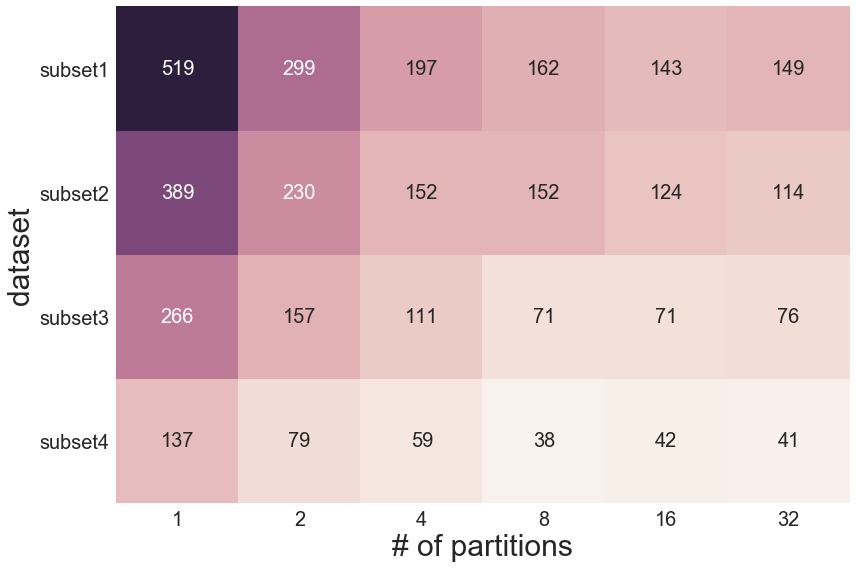

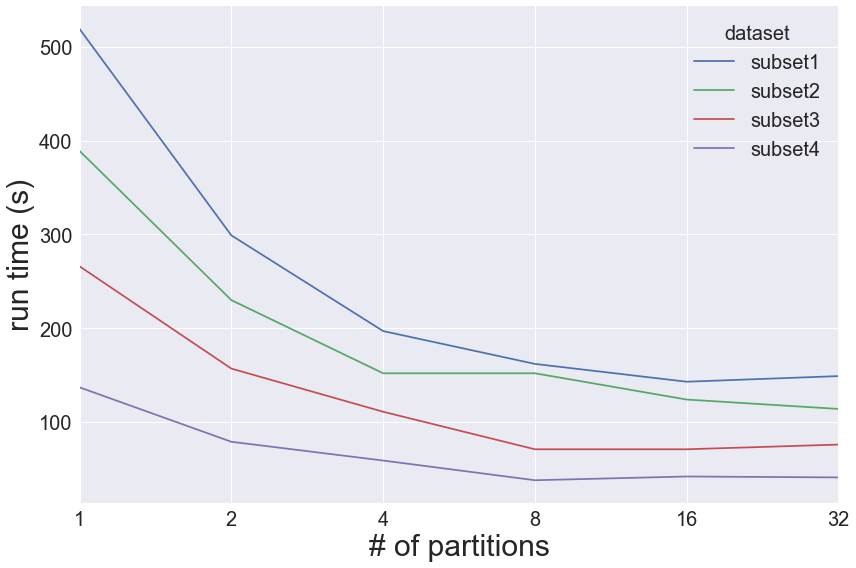

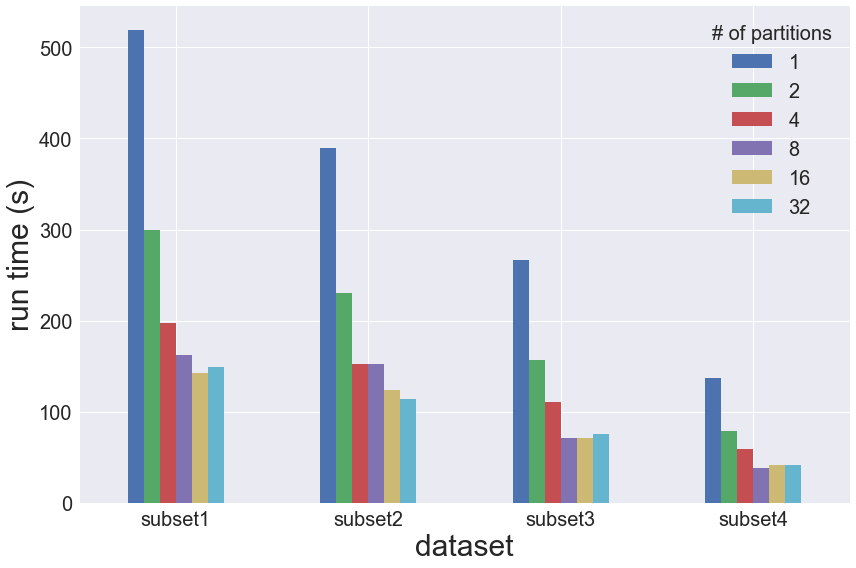

In [13]:
plot_heatmap(df.set_index('dataset'), xlabel='# of partitions', ylabel='dataset')
plt.savefig('Fig3_dataset_partitions_heatmap.png')
plot_line(df_t, xlabel='# of partitions', ylabel='run time (s)', leg_title='dataset')
plt.savefig('Fig4_dataset_partitions_ling_graph')
plot_bar(df, xlabel='dataset', ylabel='run time (s)', leg_title='# of partitions')

#### Components vs partitions

In [14]:
df = run_times[(run_times['instance_type'] == 'm3.2xlarge') &
     (run_times['instances'] == 1)] \
     .pivot(index='components', columns='partitions', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()
df.components = df.components.astype('category')

df_t = df_transpose(df)
df_t.components = df_t.components.astype('category')

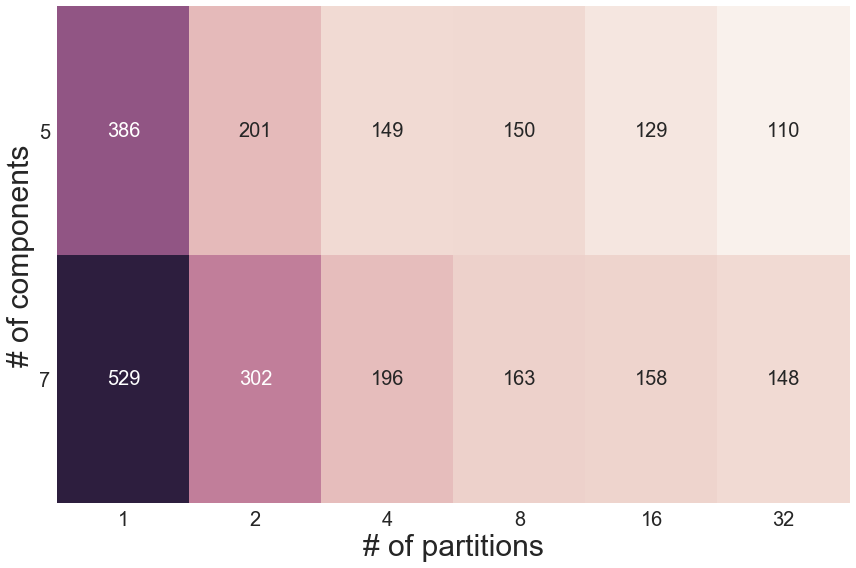

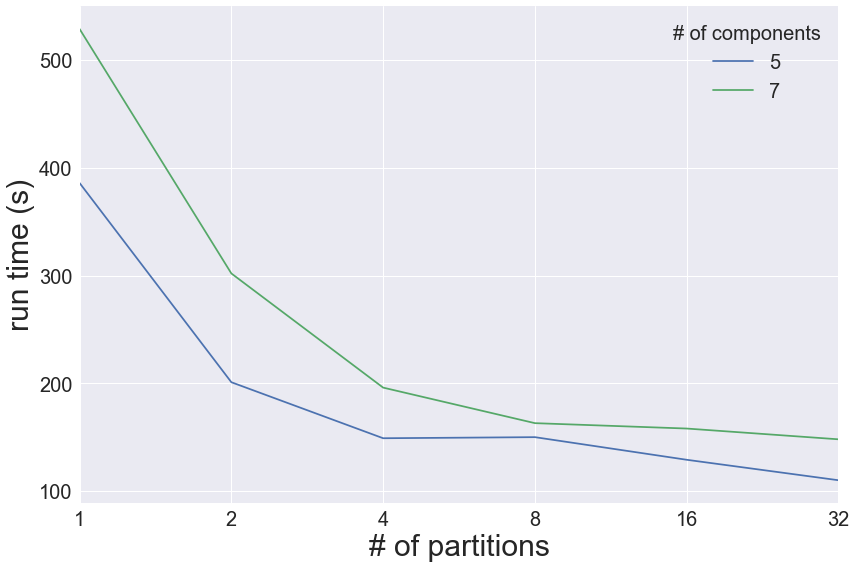

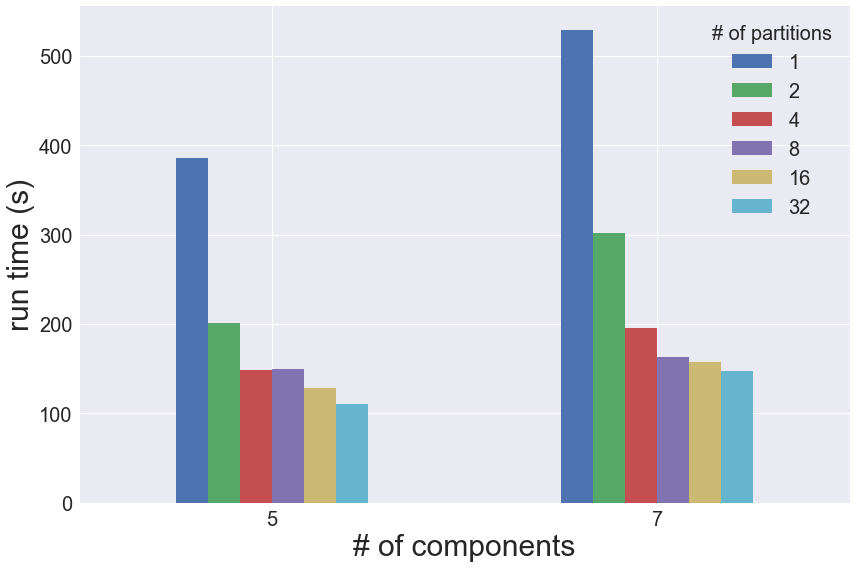

In [15]:
plot_heatmap(df.set_index('components'), xlabel='# of partitions', ylabel='# of components')
plot_line(df_t, xlabel='# of partitions', ylabel='run time (s)', leg_title='# of components')
plot_bar(df, xlabel='# of components', ylabel='run time (s)', leg_title='# of partitions')
plt.savefig('Fig5_components_partitions_bar_graph.png')

#### Instances vs partitions (m3.2xlarge)

In [16]:
df = run_times[(run_times['instance_type'] == 'm3.2xlarge') &
     (run_times['dataset'] == 'subset1') &
     (run_times['components'] == 7)] \
     .pivot(index='instances', columns='partitions', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()
df.instances = df.instances.astype('category')

df_t = df_transpose(df)
df_t.instances = df_t.instances.astype('category')

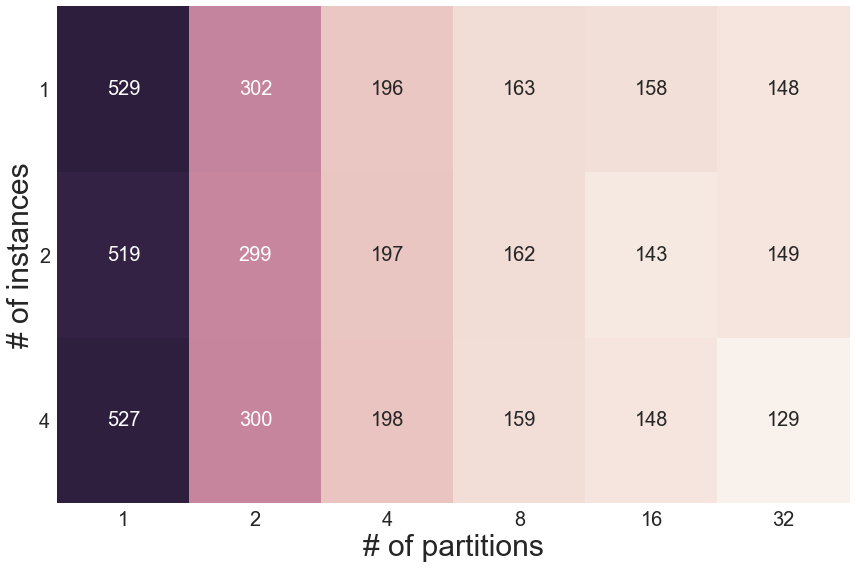

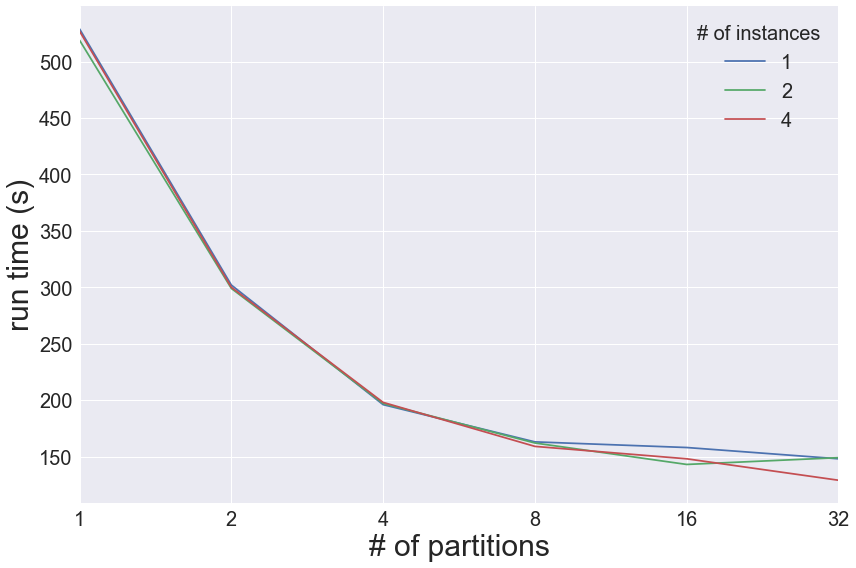

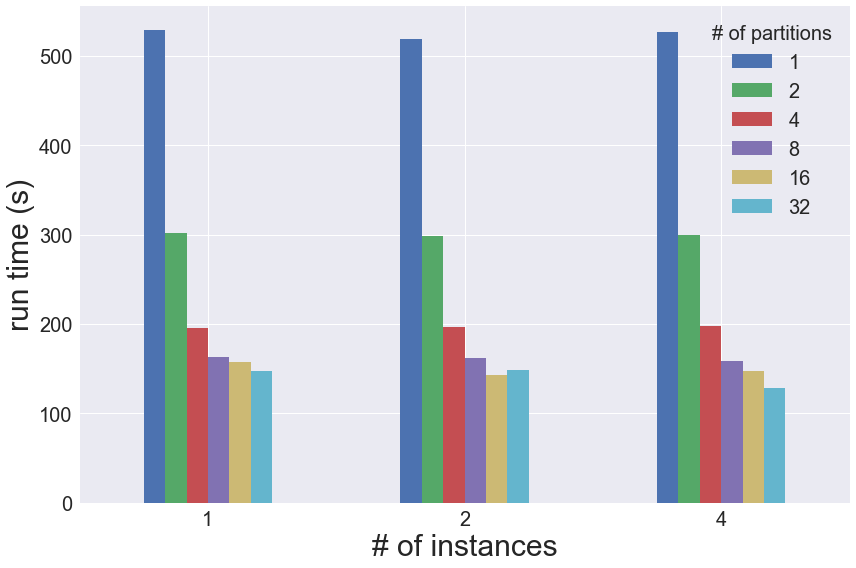

In [17]:
plot_heatmap(df.set_index('instances'), xlabel='# of partitions', ylabel='# of instances')
plot_line(df_t, xlabel='# of partitions', ylabel='run time (s)', leg_title='# of instances')
plt.savefig('Fig6_instances_partitions_line_graph.png')
plot_bar(df, xlabel='# of instances', ylabel='run time (s)', leg_title='# of partitions')

#### Instances vs partitions (m2.xlarge)

In [18]:
df = run_times[(run_times['instance_type'] == 'm2.xlarge') &
     (run_times['dataset'] == 'subset1') &
     (run_times['components'] == 7)] \
     .pivot(index='instances', columns='partitions', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()
df.instances = df.instances.astype('category')

df_t = df_transpose(df)
df_t.instances = df_t.instances.astype('category')

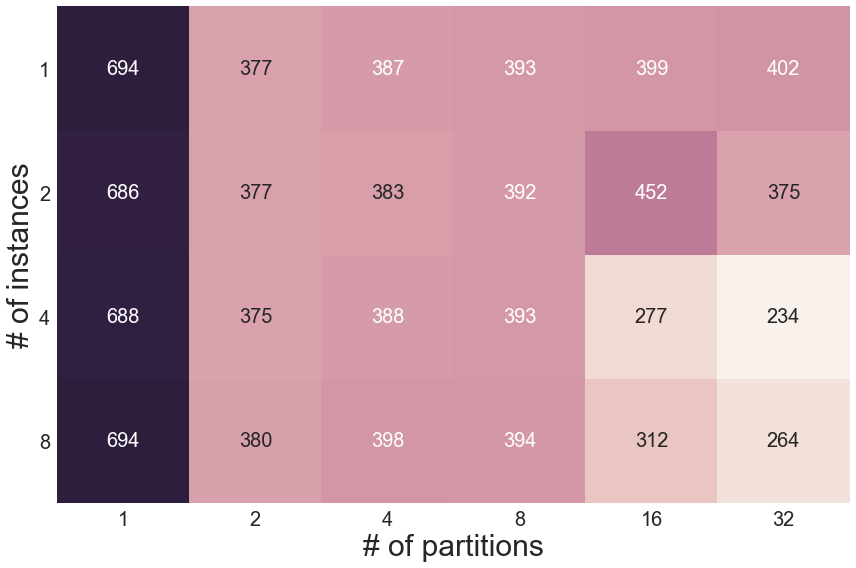

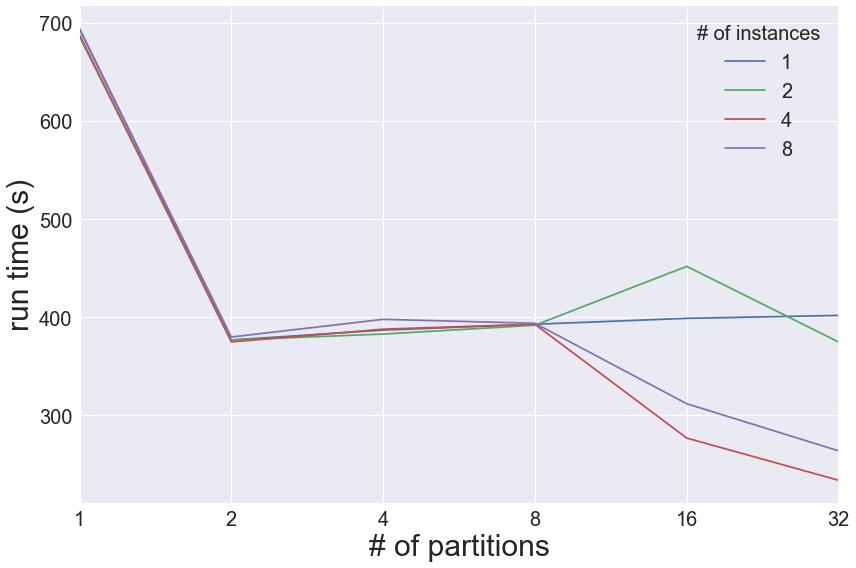

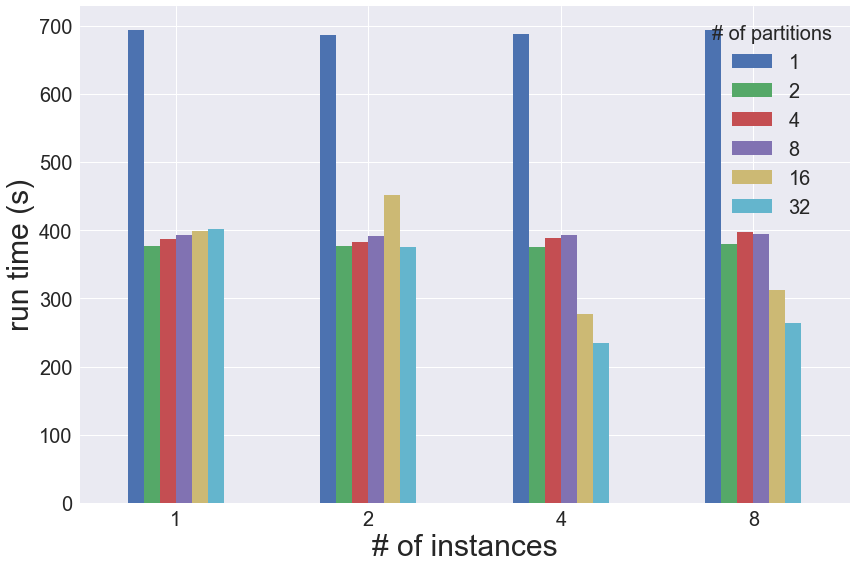

In [19]:
plot_heatmap(df.set_index('instances'), xlabel='# of partitions', ylabel='# of instances')
plt.savefig('Fig7_instances_partitions_heatmap')
plot_line(df_t, xlabel='# of partitions', ylabel='run time (s)', leg_title='# of instances')
plot_bar(df, xlabel='# of instances', ylabel='run time (s)', leg_title='# of partitions')

#### Instance type vs # of instances

In [20]:
df = run_times[(run_times['partitions'] == 32) &
     (run_times['dataset'] == 'subset1') &
     (run_times['components'] == 7) &
     (run_times['instances'] != 8)] \
     .pivot(index='instance_type', columns='instances', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()
df.instance_type = df.instance_type.astype('category')

df_t = df_transpose(df)
df_t.instance_type = df_t.instance_type.astype('category')

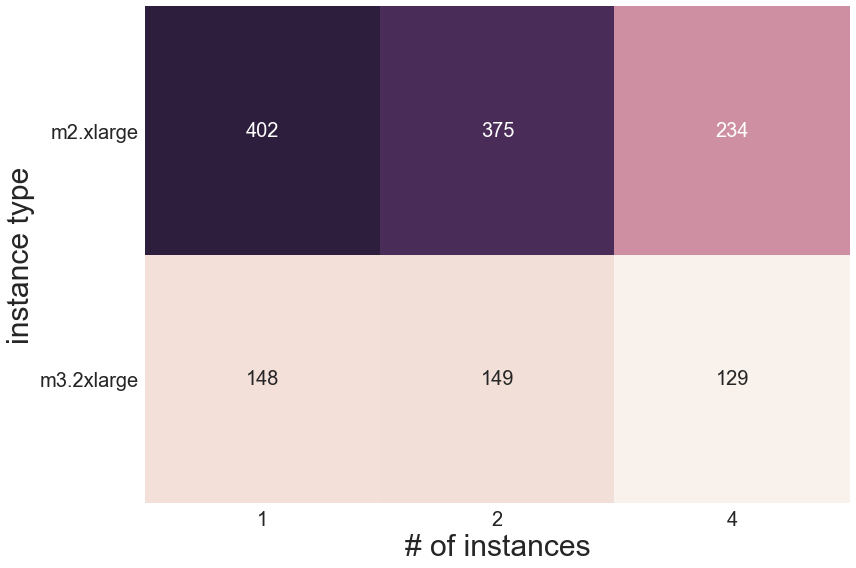

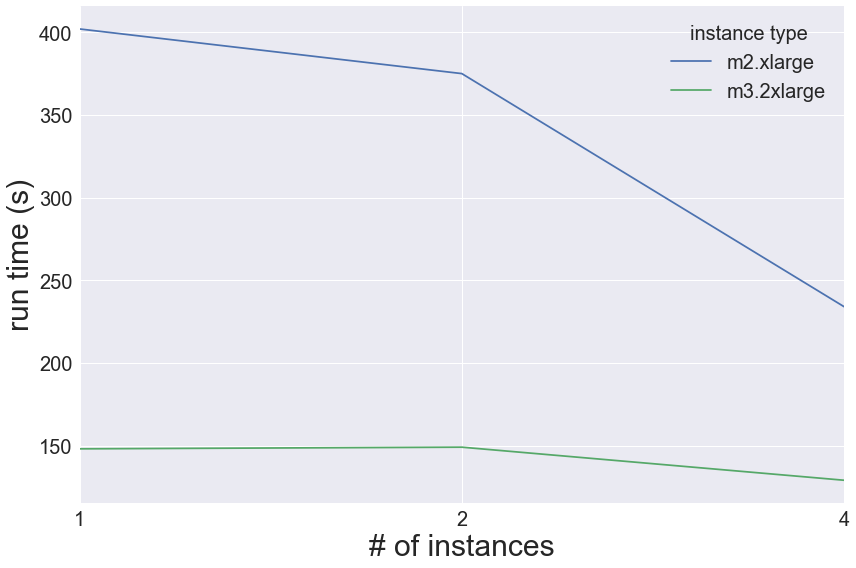

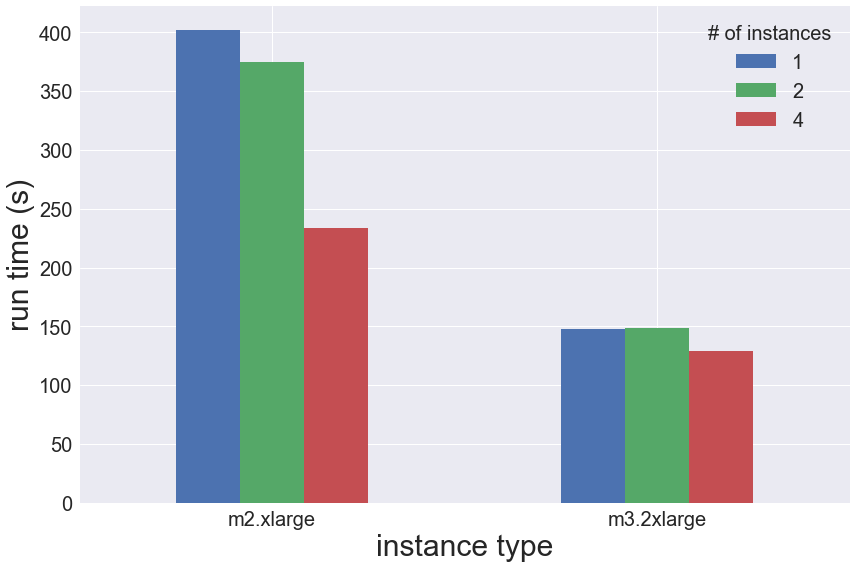

In [21]:
plot_heatmap(df.set_index('instance_type'), xlabel='# of instances', ylabel='instance type')
plot_line(df_t, xlabel='# of instances', ylabel='run time (s)', leg_title='instance type')
plot_bar(df, xlabel='instance type', ylabel='run time (s)', leg_title='# of instances')
plt.savefig('Fig8_instancetype_instances_bar_graph.png')

In [20]:
df1 = run_times[(run_times['instance_type'] == 'm3.2xlarge') &
     (run_times['dataset'] == 'subset1') &
     (run_times['components'] == 7)] \
     .pivot(index='instances', columns='partitions', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()
df1.instances = df1.instances.astype('category')

df2 = run_times[(run_times['instance_type'] == 'm2.xlarge') &
     (run_times['dataset'] == 'subset1') &
     (run_times['components'] == 7)] \
     .pivot(index='instances', columns='partitions', values='run_time') \
     .rename_axis(None, axis=1) \
     .reset_index()
df2.instances = df2.instances.astype('category')

df2_t = df_transpose(df2)
df2_t.instances = df2_t.instances.astype('category')

In [26]:
df3 = df1.append(df2)

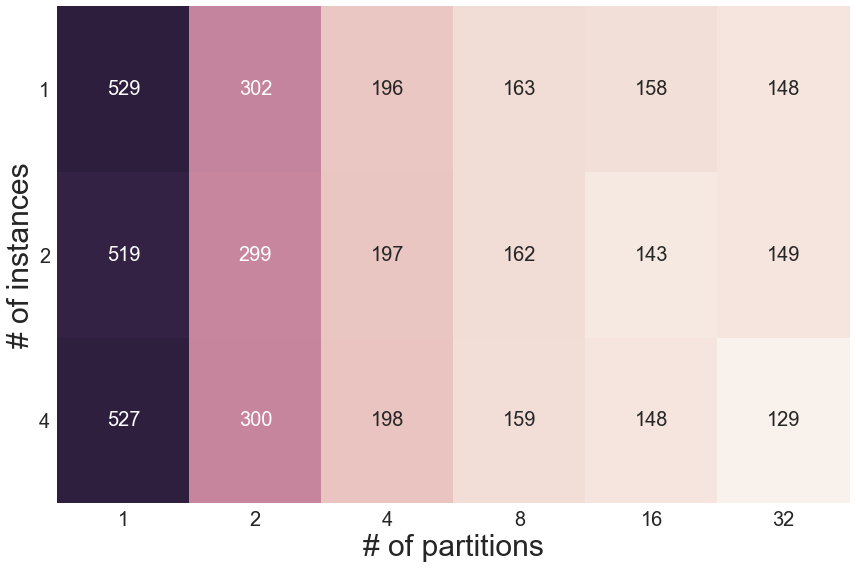

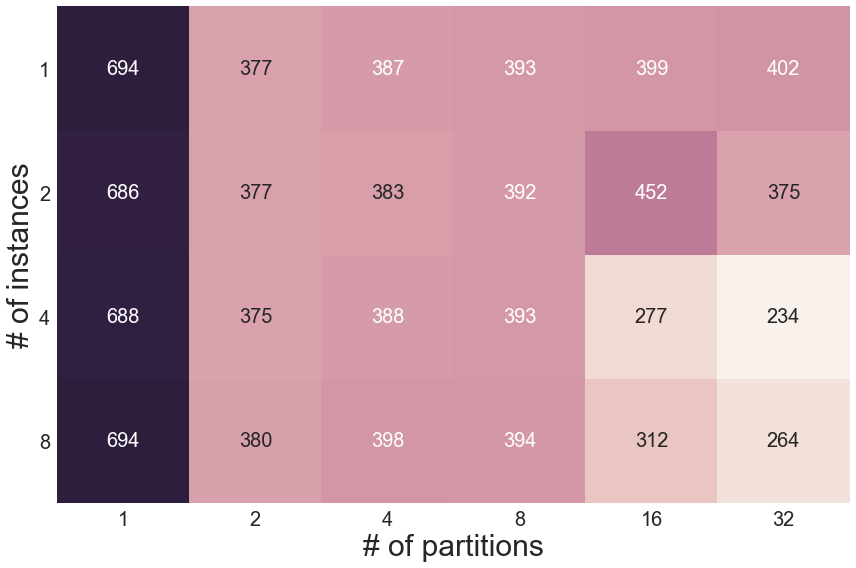

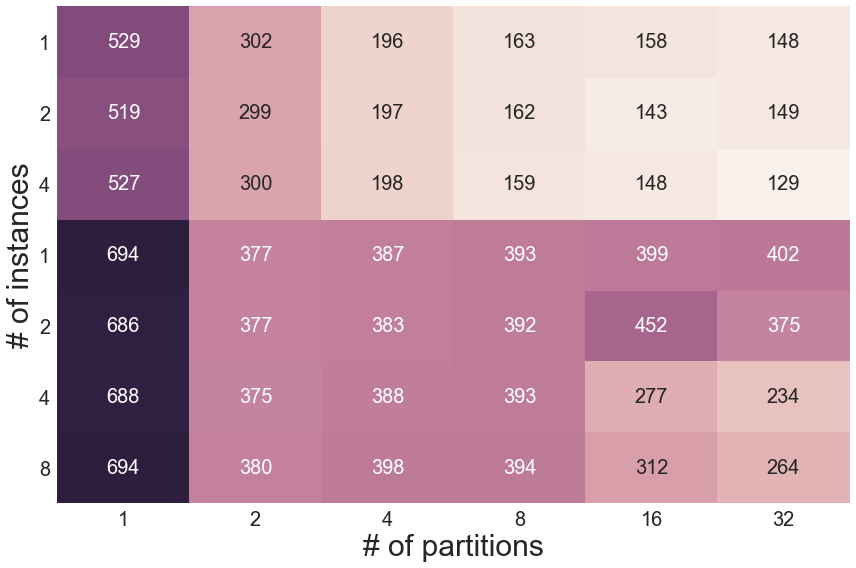

In [27]:
plot_heatmap(df1.set_index('instances'), xlabel='# of partitions', ylabel='# of instances')
plot_heatmap(df2.set_index('instances'), xlabel='# of partitions', ylabel='# of instances')
plot_heatmap(df3.set_index('instances'), xlabel='# of partitions', ylabel='# of instances')